# Experiment 1

In [2]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats

from videoannotator import config as cfg, experiments, data

In [4]:
exp = experiments.Experiment()

In [5]:
group_lookup = {
    v: k
    for k, vs in cfg.LABEL_GROUPS.items()
    for v in vs
}

In [6]:
len(group_lookup)

56

In [ ]:
# this will take a while
res = exp.experiment_active_learning_batch(
    labels=cfg.LABELS,
)

In [12]:
@dataclass(frozen=True)
class Beat:
    champ: experiments.Metric
    chall: experiments.Metric
        
    @property
    def better(self):
        if self.champ is None:
            return True
        return self.chall.mean > self.champ.mean
    
    @property
    def sig(self):
        if self.better:
            if self.champ is None: return True
            return (self.chall.mean - self.chall.std) > (self.champ.mean + self.champ.std)
        return False
    
    @property
    def lift(self):
        if self.champ and self.chall:
            return self.chall.mean / self.champ.mean - 1
    
    def __repr__(self):
        return f"Beat(better={self.better}, sig={self.sig})"

def at(l, cnt):
    d = res[l]
    cmp = {
        method: er
        for (n, method, scoring), er in d['cmp'].items()
        if n == cnt and scoring == 'average_precision'
    }
    va = [
        x
        for x in d['checkpoints']
        if len(x.lds_train) <= (cnt + 10)
    ]
    va_ap = max(va, key=lambda x: x.average_precision.mean).average_precision if len(va) > 0 else None
    return dict(
        label=l,
        baseline=d['baseline_agg'],
        zs=d['zero_shot'].average_precision,
        va_cnt=len(va[-1].lds_train) if len(va) > 0 else None,
        va=va_ap,
        cmp_zs=cmp['zero-shot'].average_precision if 'zero-shot' in cmp else None,
        cmp_random=cmp['random'].average_precision if 'random' in cmp else None,
        cmp_comb=cmp['zero-shot-50-random-50'].average_precision if 'zero-shot-50-random-50' in cmp else None,
    )

def beat_cols(champ_, chall_):
    return [
        Beat(champ=champ, chall=chall)
        for champ, chall in zip(champ_, chall_)
    ]

def analyze(cnt):
    df = pd.DataFrame(map(lambda l: at(l, cnt=cnt), res.keys()))
    n = len(df)
    df = df[df.va_cnt.notnull()]
    if len(df) < n:
        print(f'lost {n - len(df)} / {n} for cnt= {cnt}')
    return df.assign(
        va_beats_bl=beat_cols(df.baseline, df.va),
        va_beats_zs=beat_cols(df.zs, df.va),
        va_beats_cmp_zs=beat_cols(df.cmp_zs, df.va),
        va_beats_cmp_rand=beat_cols(df.cmp_random, df.va),
        va_beats_cmp_comb=beat_cols(df.cmp_comb, df.va),
        cnt=cnt,
    )

def agg(df, sig):
    df = df.groupby('cnt').apply(
        lambda rows: pd.Series(dict(
            beats_baseline=rows.va_beats_bl.apply(lambda x: x.better).mean(),
            beats_baseline_sig=rows.va_beats_bl.apply(lambda x: x.sig).mean(),
            beats_zs=rows.va_beats_zs.apply(lambda x: x.better).mean(),
            beats_zs_sig=rows.va_beats_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_rand=rows.va_beats_cmp_rand.apply(lambda x: x.better).mean(),
            beats_cmp_rand_sig=rows.va_beats_cmp_rand.apply(lambda x: x.sig).mean(),
            beats_cmp_zs=rows.va_beats_cmp_zs.apply(lambda x: x.better).mean(),
            beats_cmp_zs_sig=rows.va_beats_cmp_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_comb=rows.va_beats_cmp_comb.apply(lambda x: x.better).mean(),
            beats_cmp_comb_sig=rows.va_beats_cmp_comb.apply(lambda x: x.sig).mean(),
        ))
    )
    cols = [c for c in df.columns if ((sig and '_sig' in c) or (not sig and '_sig' not in c))]
    return df[cols]

In [13]:
df = pd.concat([
    analyze(n)
    for n in (25, 50, 100, 500, 1000)
])

WARNING 2023-12-28 21:15:40,039 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,040 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,040 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,041 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,041 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,042 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,042 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-12-28 21:15:40,043 experiments.py(32) Metric has NaN values: (0.3333333333

lost 23 / 56 for cnt= 25
lost 7 / 56 for cnt= 50
lost 4 / 56 for cnt= 100


In [14]:
len(df)

246

In [15]:
d = df.assign(group=df.label.map(group_lookup))
d.groupby('group').label.nunique().sort_values(ascending=False)

group
shot_types        22
sensitivities      7
genres             6
motion             6
emotions           5
events_actions     4
focus              3
time_location      3
Name: label, dtype: int64

In [16]:
cols = [c for c in d.columns if 'va_beats_' in c]

In [17]:
vals = df[df.cnt == 25].va_beats_cmp_comb
len(vals)

33

WARNING 2023-12-28 21:35:25,136 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:35:25,168 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-12-28 21:35:25,174 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:35:25,183 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:35:25,184 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:35:25,317 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-12-28 21:35:25,323 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:35:25,333 experiments.py(32) Metric 

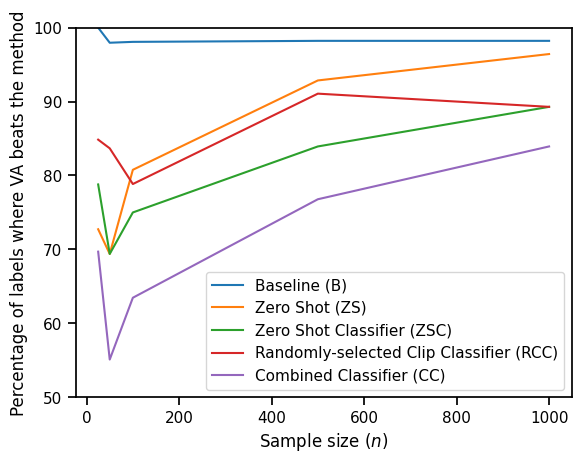

In [54]:
q = (df.groupby('cnt').apply(lambda xs: pd.Series({
    c: sum(
        (x.lift and x.lift >= 0) or (x.chall is not None and x.champ is None)
        for x in xs[c]
    ) / sum(
        x.chall is not None
        for x in xs[c]
    )
    for c in df.columns if '_beats_' in c
})) * 100)
q.rename(columns={
    'va_beats_bl': 'Baseline (B)',
    'va_beats_zs': 'Zero Shot (ZS)',
    'va_beats_cmp_zs': 'Zero Shot Classifier (ZSC)',
    'va_beats_cmp_rand': 'Randomly-selected Clip Classifier (RCC)',
    'va_beats_cmp_comb': 'Combined Classifier (CC)',
}).plot()
plt.ylim([50, 100])
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels where VA beats the method')

In [46]:
q

,va_beats_bl,va_beats_zs,va_beats_cmp_zs,va_beats_cmp_rand,va_beats_cmp_comb
cnt,,,,,
25,100.000000,72.727273,78.787879,84.848485,69.696970
50,97.959184,69.387755,69.387755,83.673469,55.102041
100,98.076923,80.769231,75.000000,78.846154,63.461538
500,98.214286,92.857143,83.928571,91.071429,76.785714
1000,98.214286,96.428571,89.285714,89.285714,83.928571


In [100]:
def _get_gains(df, c):
    return [
        x.lift
        for x in df[c]
        if x.lift
    ]


def _get_diff(df, c):
    return [
        x.chall.mean - x.champ.mean
        for x in df[c]
        if x.lift
    ]

def f(df, col=None):
    rows = []

    cs = cols if col is None else [col]
    for c in cs:
        # vals = df.groupby('group')[c].apply(lambda x: np.mean([a.better for a in x]))
        gain = _get_diff(df, c)
        if len(gain) == 0:
            x = 'nan'
            continue
        gain_neg = sum(1 for x in gain if x < 0)
        # vals_sig = df.groupby('group')[c].apply(lambda x: np.mean([a.sig for a in x]))
        # m, s = np.mean(vals), np.std(vals)
        # m, s = np.median(gain), np.std(gain)
        # s = stats.iqr(gain)
        # x = f'{m:.2f} ± {s:.1f} ({len(gain)}, {gain_neg})'
        n = len(gain)
        # x = f'{100 * m:.0f}% | {100 * np.percentile(gain, q=25):.0f}% | {100 * n / len(cfg.LABELS):.0f}% | {100 * (1 - gain_neg / n):.0f}%'
        # x = f'{100 * np.percentile(gain, q=25):.0f}% | {100 * np.percentile(gain, q=50):.0f}% | {100 * np.percentile(gain, q=75):.0f}%'
        x = f'{100 * np.mean(gain):.0f}%'
        x = np.mean(gain)
        x = np.percentile(gain, q=50)
        # x = f'{m:.2f} ± {np.mean(vals_sig):.2f}'
        rows.append(dict(c=c, val=x))
        # rows.append(dict(c=c, val=m))

    if col is None:
        return pd.DataFrame(rows).set_index('c')
    else:
        return pd.Series([x['val'] for x in rows], index=[x['c'] for x in rows])
    
def coverage(df):
    cs = ['va_beats_cmp_zs', 'va_beats_cmp_rand', 'va_beats_cmp_comb']
    return pd.Series([
        sum(
            x.champ is not None
            for x in df[c]
        ) / len(cfg.LABELS)
        for c in cs
    ], index=cs)


def lift(df, q, col=None):
    cs = [c for c in cols if 'bl' not in c] if col is None else [col]
    return pd.Series([
        np.percentile(_get_diff(df, c), q=q)
        for c in cs
    ], index=cs)

WARNING 2023-12-28 21:15:53,709 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:53,710 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-12-28 21:15:53,715 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:15:53,724 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-12-28 21:15:53,725 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:15:53,730 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-12-28 21:15:53,736 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-12-28 21:15:53,745 experiments.py(32) Metric 

<AxesSubplot:xlabel='cnt'>

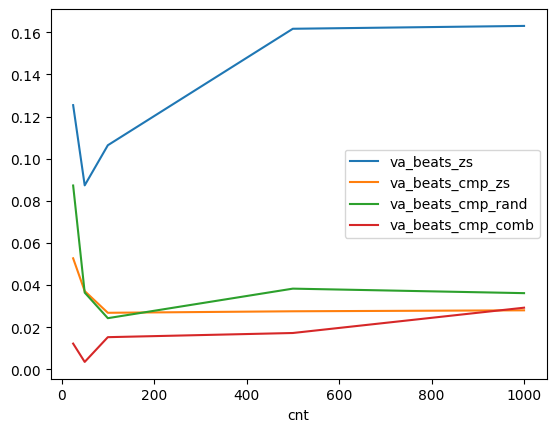

In [20]:
d.groupby('cnt').apply(lambda df: lift(df, q=50, col=None)).plot()

In [21]:
d.groupby('cnt').apply(coverage)

,va_beats_cmp_zs,va_beats_cmp_rand,va_beats_cmp_comb
cnt,,,
25,0.482143,0.339286,0.535714
50,0.821429,0.517857,0.821429
100,0.910714,0.660714,0.892857
500,0.982143,0.892857,0.982143
1000,0.982143,0.928571,0.982143


In [22]:
df_cnt = pd.DataFrame(
    dict(
        l=l,
        cnt_zs=data.CompDataset(l).get_ordered_dataset_zero_shot().get_n(25).lds.pos_cnt,
        cnt_rand=data.CompDataset(l).get_ordered_dataset_random().get_n(25).lds.pos_cnt,
    )
    for l in cfg.LABELS
).set_index('l')

WARNING 2023-12-28 21:15:57,022 data.py(64) LabeledDataset(label=jump-scare, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2023-12-28 21:15:57,070 data.py(64) LabeledDataset(label=shutter-shot, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2023-12-28 21:15:57,071 data.py(64) LabeledDataset(label=shutter-shot, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2023-12-28 21:15:57,083 data.py(64) LabeledDataset(label=alcohol, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2023-12-28 21:15:57,088 data.py(64) LabeledDataset(label=timelapse, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.


In [23]:
(df_cnt >= 23).mean()

cnt_zs      0.035714
cnt_rand    0.000000
dtype: float64

In [24]:
56 - (df_cnt <= 1).sum()

cnt_zs      48
cnt_rand    17
dtype: int64

In [25]:
(df_cnt == 25).sum()

cnt_zs      0
cnt_rand    0
dtype: int64

In [34]:
import seaborn as sns

In [35]:
sns.set_context('notebook')

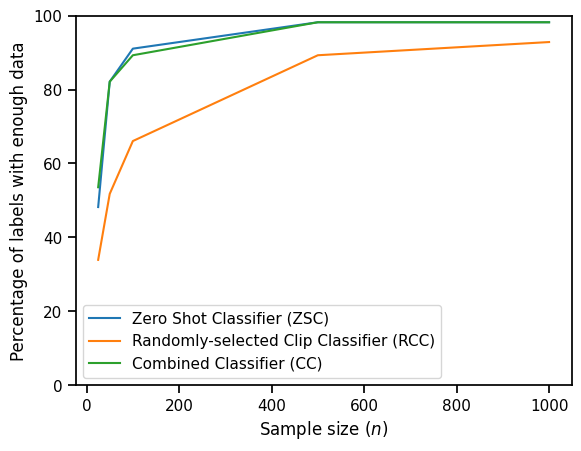

In [57]:
cov = d.groupby('cnt').apply(coverage) * 100
cov.rename(columns=dict(
    va_beats_cmp_zs='Zero Shot Classifier (ZSC)',
    va_beats_cmp_rand='Randomly-selected Clip Classifier (RCC)',
    va_beats_cmp_comb='Combined Classifier (CC)',
)).plot()
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels with enough data')
_ = plt.ylim([0, 100])

In [58]:
# d.groupby('cnt').apply(coverage).plot()
# plt.ylim([0, 1])

In [65]:
q = d.groupby('cnt').apply(f).unstack().T
q

WARNING 2024-01-03 21:05:16,943 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 21:05:16,976 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-01-03 21:05:16,982 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 21:05:16,991 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 21:05:16,992 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 21:05:17,126 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-01-03 21:05:17,132 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 21:05:17,142 experiments.py(32) Metric 

cnt                               25               50               100   \
    c                                                                      
val va_beats_bl        18% | 30% | 43%  19% | 31% | 44%  22% | 34% | 44%   
    va_beats_zs         -0% | 9% | 19%   -1% | 9% | 19%   4% | 12% | 22%   
    va_beats_cmp_zs     -0% | 7% | 11%   -1% | 5% | 10%    -0% | 5% | 7%   
    va_beats_cmp_rand    0% | 8% | 18%   -0% | 6% | 12%   -1% | 7% | 14%   
    va_beats_cmp_comb    -5% | 1% | 6%   -4% | -0% | 4%    -2% | 1% | 6%   

cnt                               500              1000  
    c                                                    
val va_beats_bl        32% | 40% | 49%  33% | 41% | 49%  
    va_beats_zs         8% | 19% | 29%  10% | 20% | 31%  
    va_beats_cmp_zs       1% | 5% | 7%     1% | 4% | 6%  
    va_beats_cmp_rand    2% | 8% | 11%     1% | 7% | 8%  
    va_beats_cmp_comb     0% | 4% | 5%     1% | 4% | 5%

In [79]:
q = d.va_beats_cmp_comb.iloc[0]
q

Beat(better=True, sig=False)

In [82]:
q.chall.mean - q.champ.mean

0.04581717632414828

In [87]:
d.va_beats_cmp_comb.apply(lambda x: x.chall.mean - x.champ.mean if x is not None and x.chall is not None and x.champ is not None else None).describe()

WARNING 2024-01-03 22:38:34,933 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 22:38:34,934 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 22:38:34,938 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


count    236.000000
mean       0.021104
std        0.086745
min       -0.233333
25%       -0.008123
50%        0.016565
75%        0.052902
max        0.531015
Name: va_beats_cmp_comb, dtype: float64

In [88]:
d.va_beats_cmp_comb.apply(lambda x: x.lift).describe()

WARNING 2024-01-03 22:38:58,940 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 22:38:58,941 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 22:38:58,945 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


count    236.000000
mean       0.068553
std        0.295836
min       -0.329412
25%       -0.012130
50%        0.021657
75%        0.084782
max        2.909994
Name: va_beats_cmp_comb, dtype: float64

In [101]:
(d.groupby(['cnt', 'group']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1).droplevel(0) #.to_latex()

WARNING 2024-01-03 23:02:01,202 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 23:02:01,203 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 23:02:01,214 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


cnt,25,50,100,500,1000
group,,,,,
emotions,-6.0,-5.1,-4.2,2.5,3.7
events_actions,6.9,5.5,5.7,3.1,3.8
focus,1.2,-1.2,-0.4,0.3,1.8
genres,6.6,5.3,3.9,1.2,1.8
motion,31.5,1.2,5.6,1.2,3.0
sensitivities,0.5,-0.3,0.8,2.6,3.4
shot_types,1.2,0.6,0.5,2.3,2.3
time_location,4.6,-8.5,1.3,1.3,1.4


In [102]:
(d.groupby(['cnt']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1)

WARNING 2024-01-03 23:02:06,961 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-01-03 23:02:06,962 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-01-03 23:02:06,968 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


                   cnt 
va_beats_cmp_comb  25      1.2
                   50      0.4
                   100     1.5
                   500     1.7
                   1000    2.9
dtype: float64

In [38]:
# d.groupby(['cnt', 'group']).apply(lambda x: f(x, col='va_beats_zs')).unstack().T

In [39]:
# d[d.group == 'sensitivities'].groupby(['cnt']).apply(f).unstack().T

In [40]:
# d[d.group == 'motion'].groupby(['cnt']).apply(f).unstack().T

### compute diversity at different cnt

in the other nb exp000

In [33]:
# d[d.cnt == 25].groupby(['group']).apply(lambda x: pd.Series({
#     c: x[c].apply(lambda x: x.better).mean()
#     for c in cols
# })).round(1)

WARNING 2023-10-10 01:30:17,591 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:17,681 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-10-10 01:30:17,701 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:17,701 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:17,715 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:17,977 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2023-10-10 01:30:17,997 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:17,998 experiments.py(32) Metric 

(50.0, 100.0)

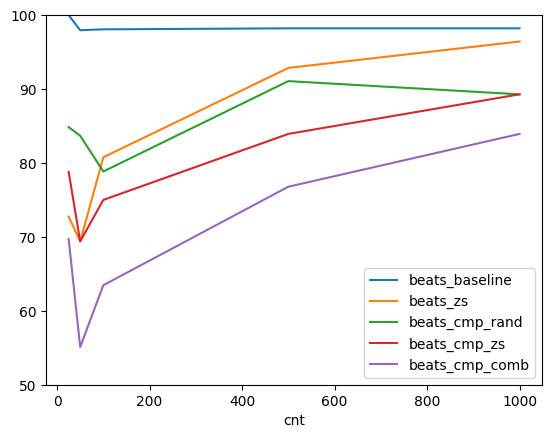

In [41]:
(agg(df, sig=False) * 100).plot()
plt.ylim([50, 100])

In [32]:
# agg(df, sig=True).plot()
# plt.ylim([0, 1])

In [42]:
def plot(res, label):
    try:
        pd.DataFrame(
            dict(
                n=n,
                method=method,
                r=r.average_precision.mean,
            )
            for (n, method, scoring), r in res[label]['cmp'].items()
            if scoring == 'average_precision'
        ).pivot_table(index='n', columns='method', values='r').plot()
    except Exception as e:
        print(f'failed {label} error: {e}')
    pd.DataFrame(
        dict(n=len(er.lds_train), ap=er.average_precision.mean)
        for er in res[label]['checkpoints']
    ).set_index('n').ap.plot()
    plt.hlines(
        res[label]['baseline_agg'].mean,
        xmin=0,
        xmax=1000,
        colors='r',
        linestyles='dotted',
    )
    plt.hlines(
        res[label]['zero_shot'].average_precision.mean,
        xmin=0,
        xmax=1000,
        colors='k',
        linestyles='dotted',
    )
    plt.ylim([0, 1])
    # res[label]['baseline_agg'].mean
    # TODO: add CI bands
    plt.title(label)
    plt.show()

In [3]:
pickle.dump

<function _pickle.dump(obj, file, protocol=None, *, fix_imports=True)>

In [44]:
ap_va_best = {
    l: dict(
        last=res[l]['checkpoints'][-1].average_precision.mean,
        best=max(
            res[l]['checkpoints'],
            key=lambda x: (
                x.average_precision.mean
                if x.average_precision.mean is not None
                else -1
            ),
        ).average_precision.mean
    )
    for l in cfg.LABELS
}
# this object is used for experiment 2
pickle.dump(ap_va_best, open('ap_va_best.pkl', 'wb'))

WARNING 2023-10-10 01:30:25,360 experiments.py(32) Metric has NaN values: (0.2, nan, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333)
WARNING 2023-10-10 01:30:25,361 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,362 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,362 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,363 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,364 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,364 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-10-10 01:30:25,365 experiments.py(32) Metric has NaN values:

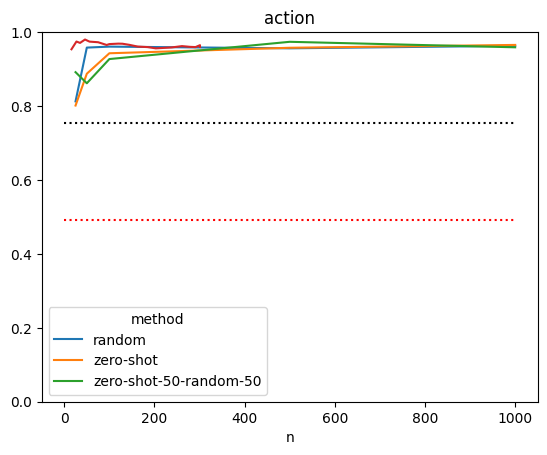

===


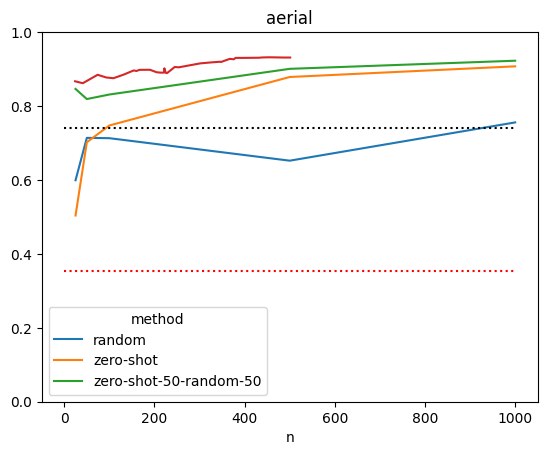

===


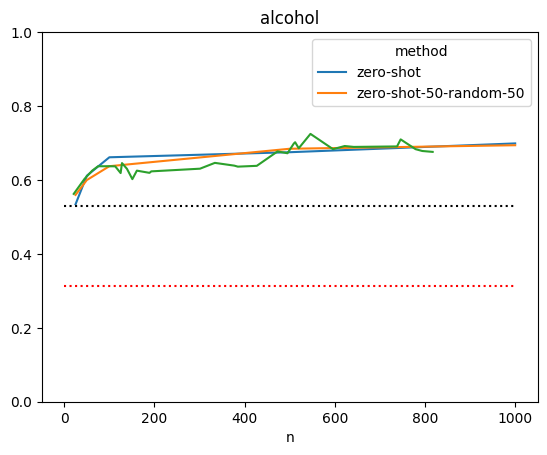

===


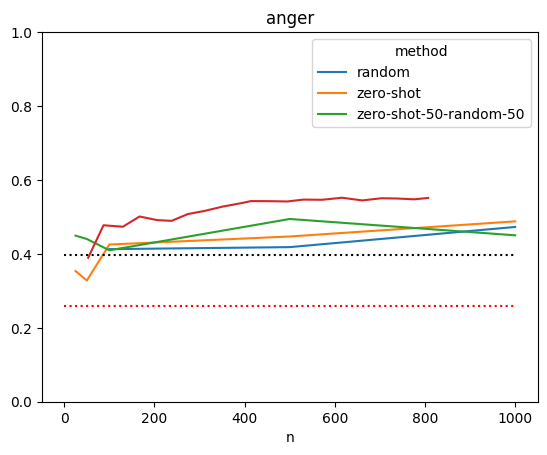

===


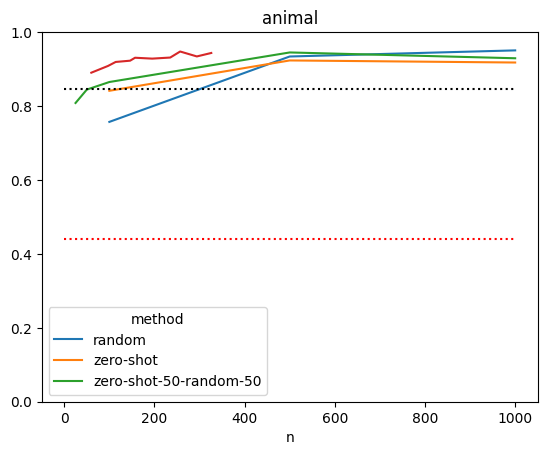

===


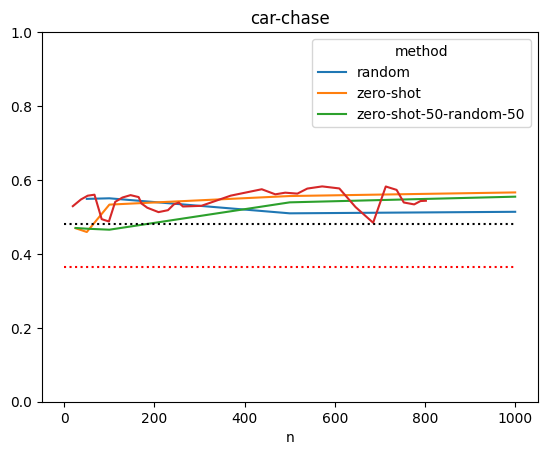

===


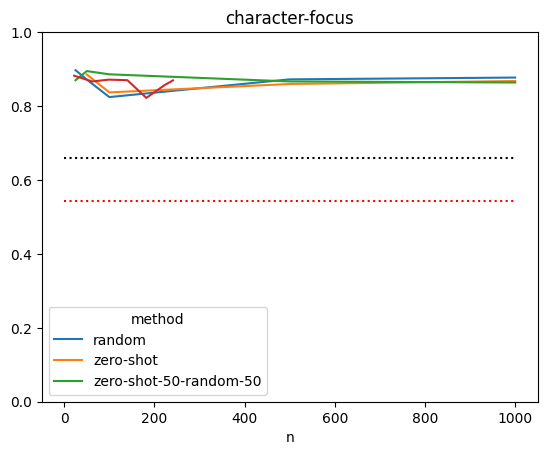

===


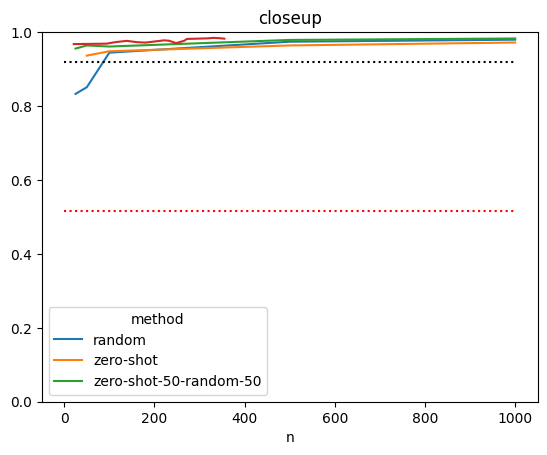

===


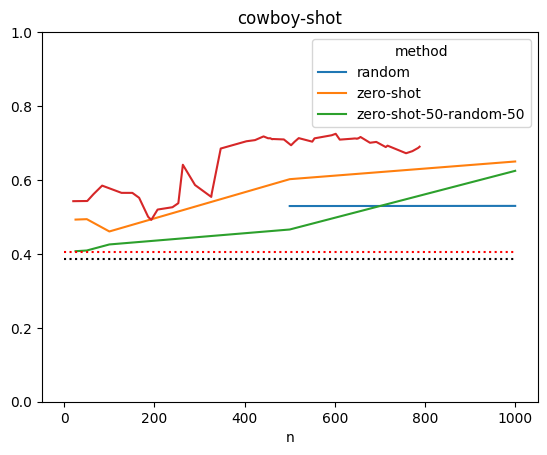

===


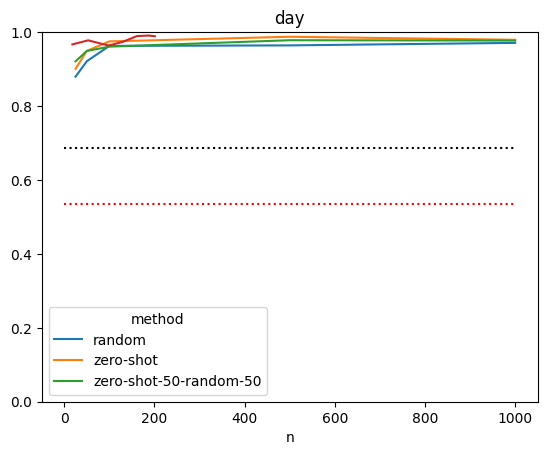

===


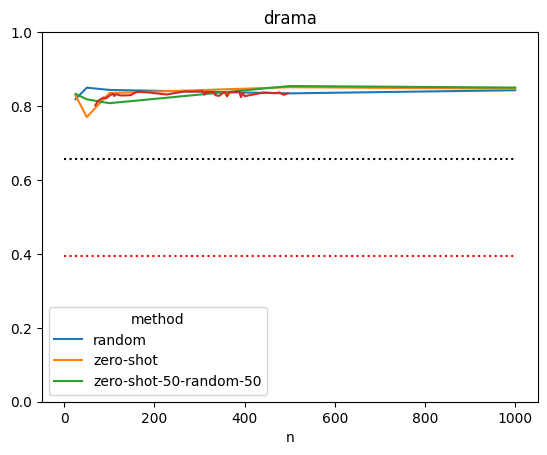

===


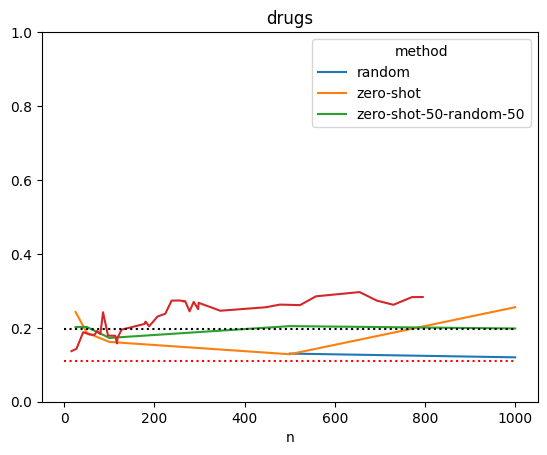

===


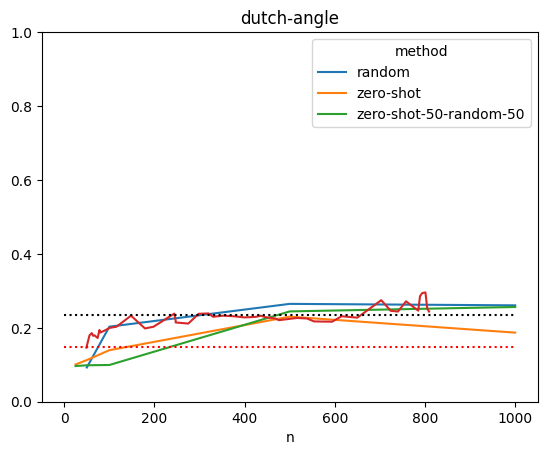

===


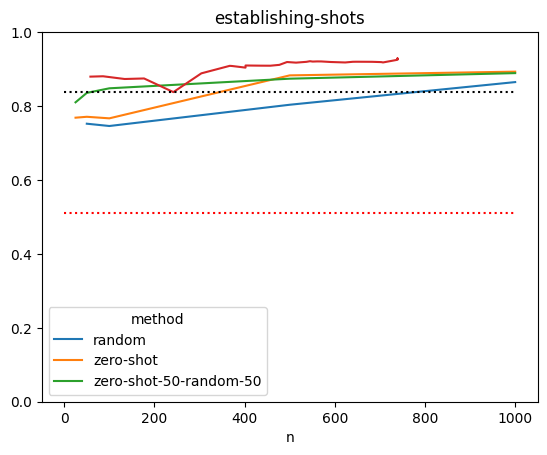

===


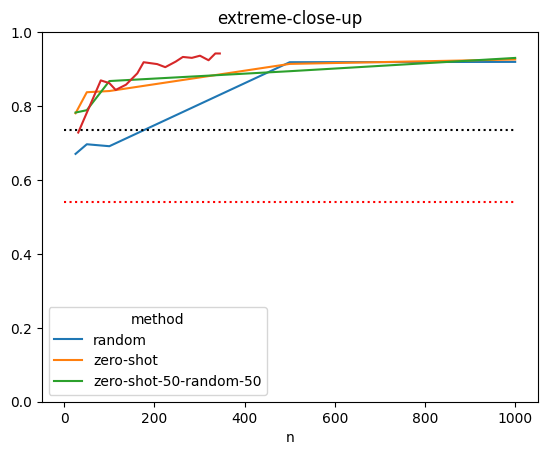

===


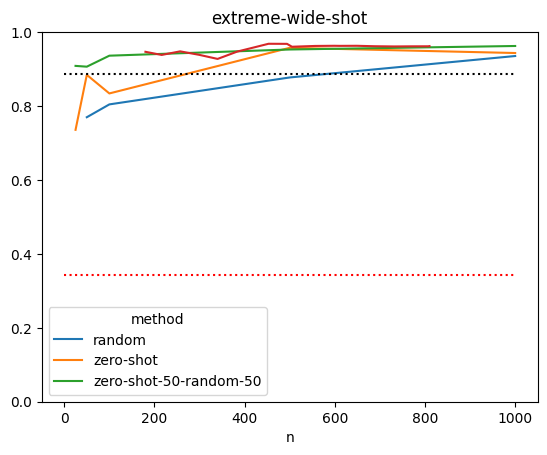

===


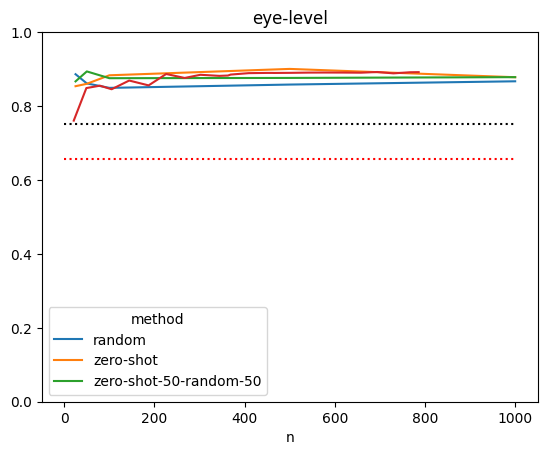

===


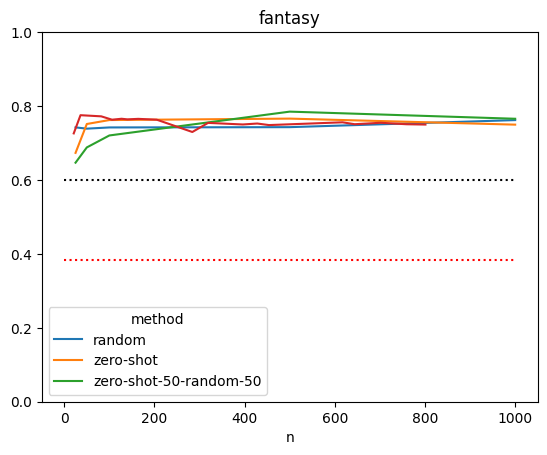

===


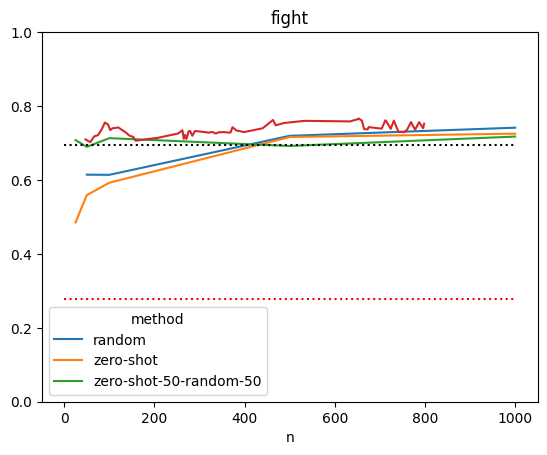

===


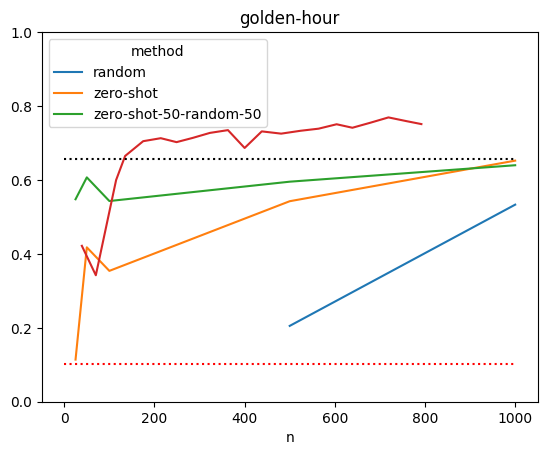

===


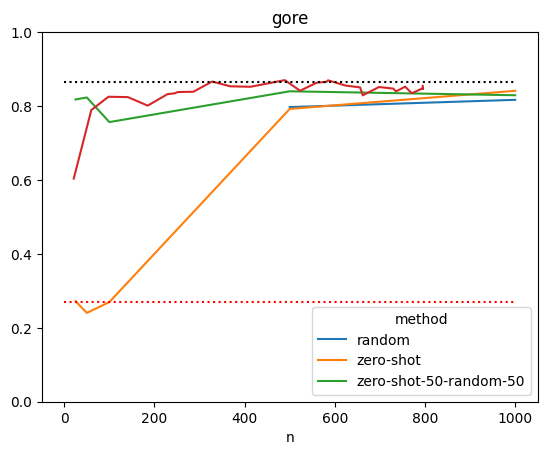

===


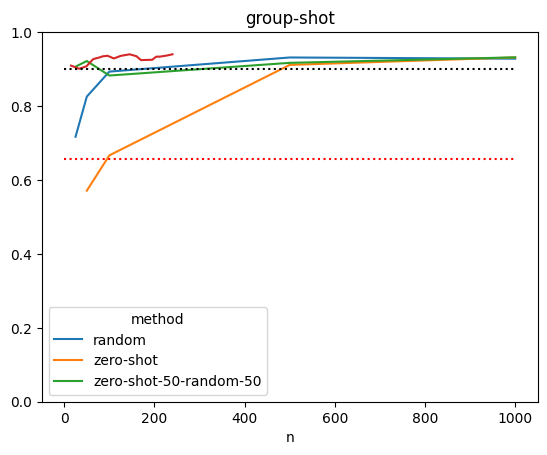

===


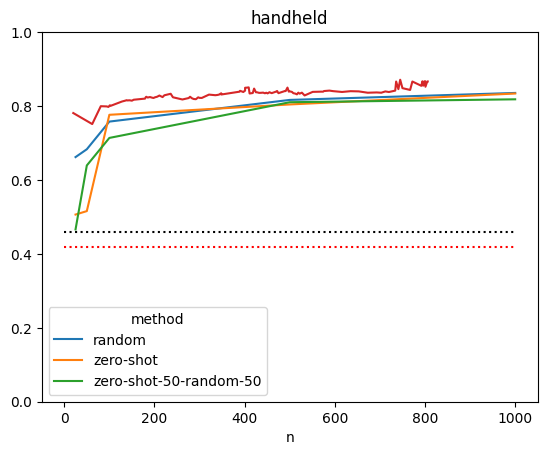

===


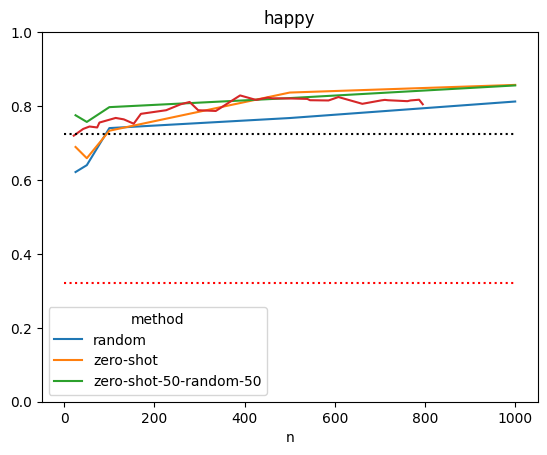

===


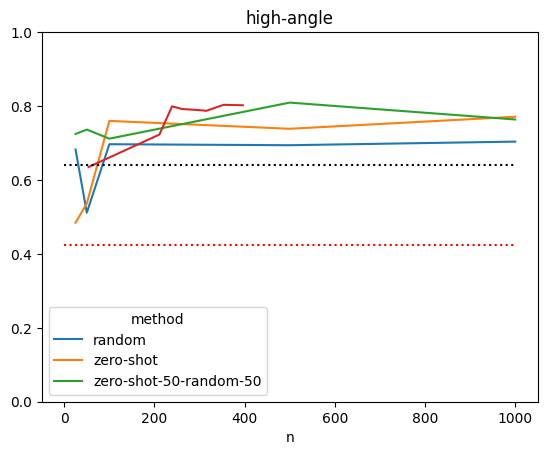

===


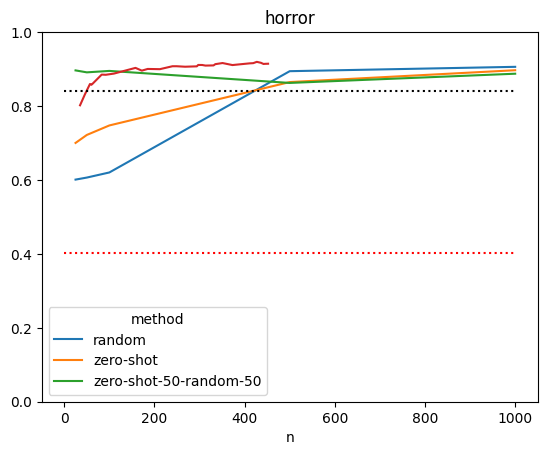

===


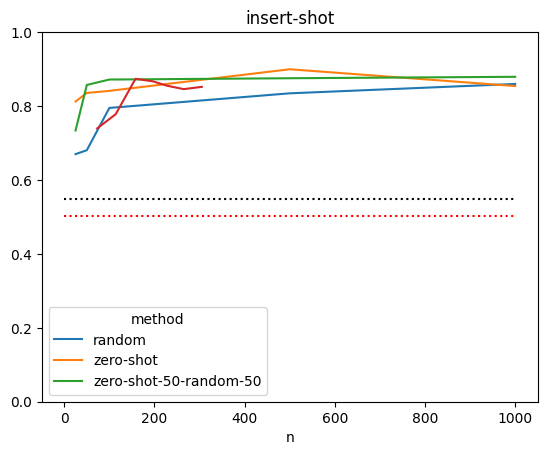

===


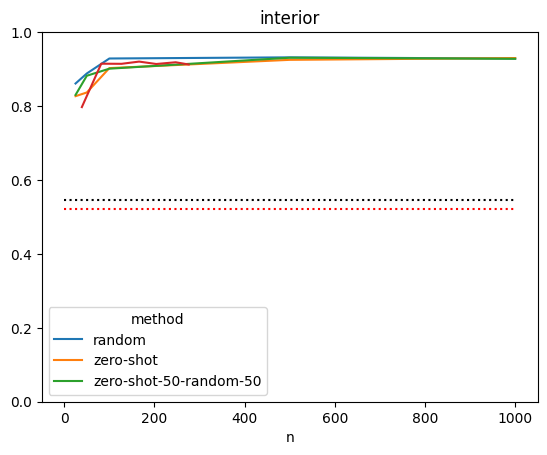

===


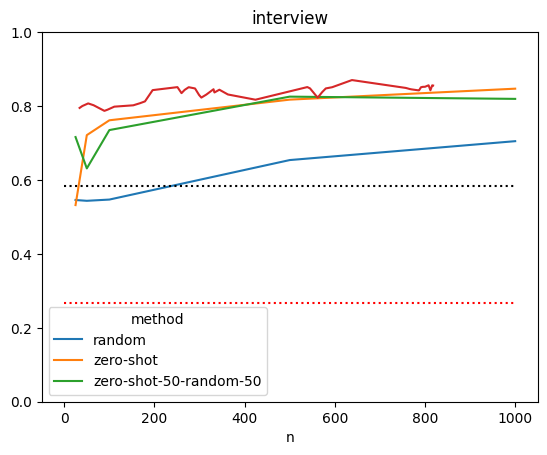

===


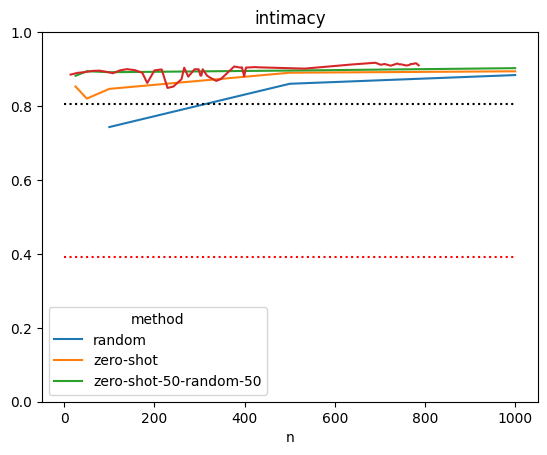

===


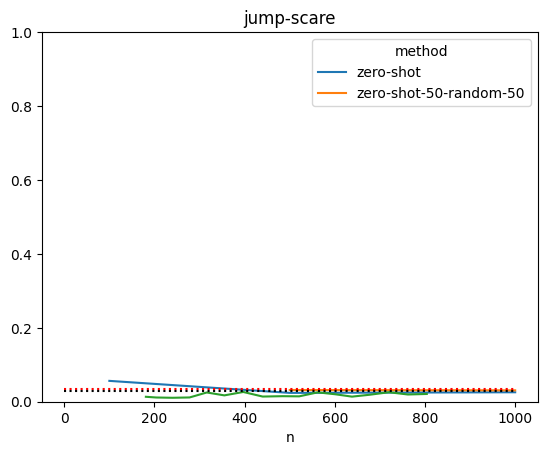

===


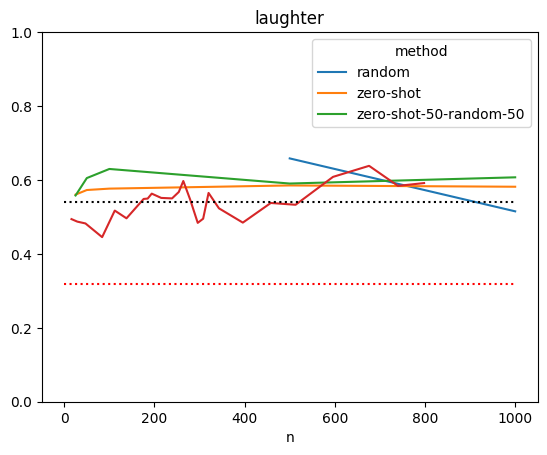

===


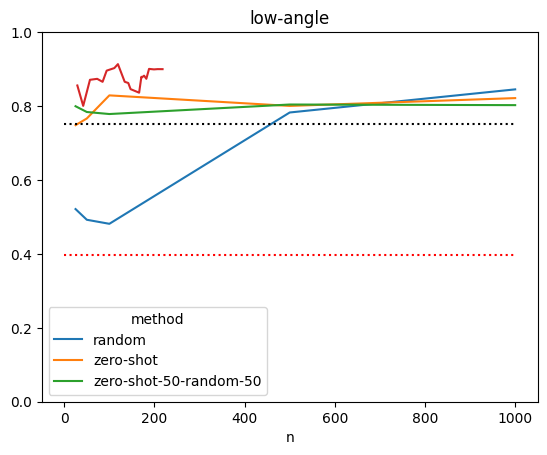

===


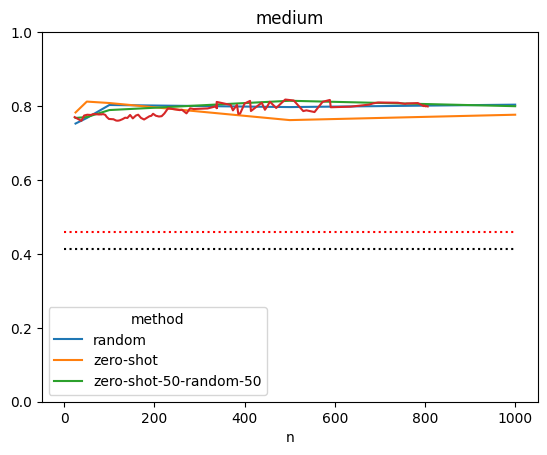

===


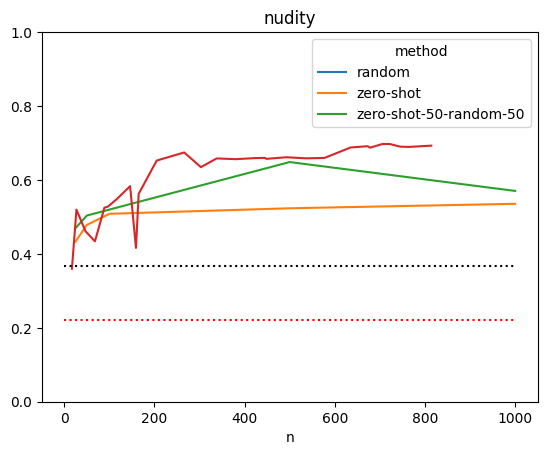

===


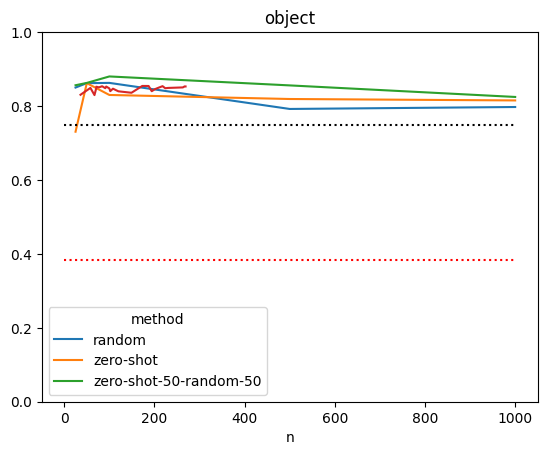

===


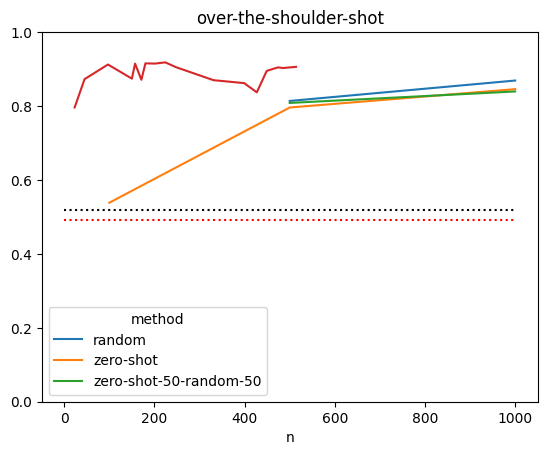

===


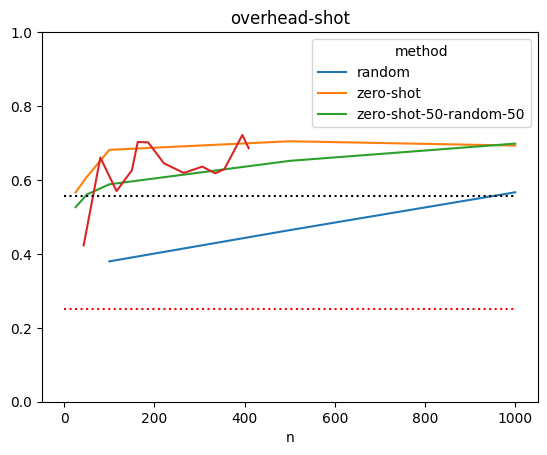

===


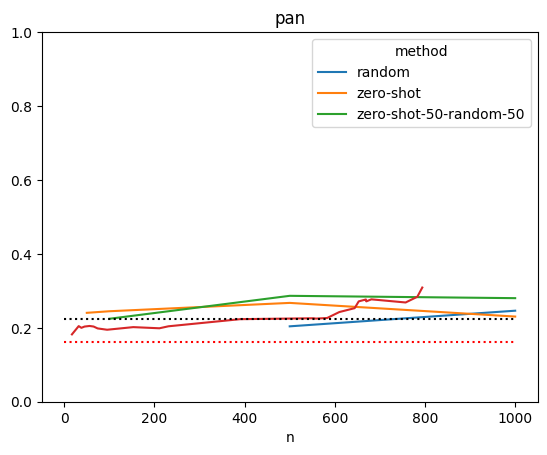

===


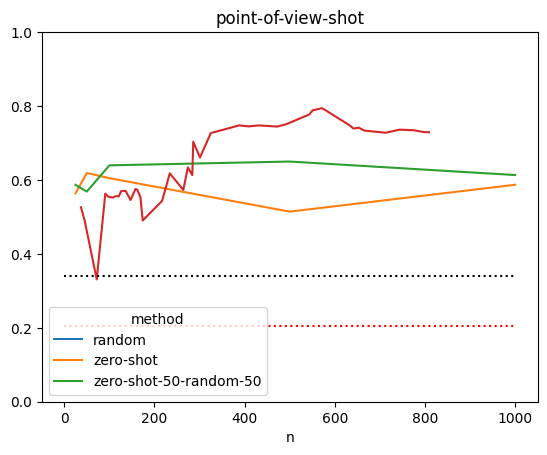

===


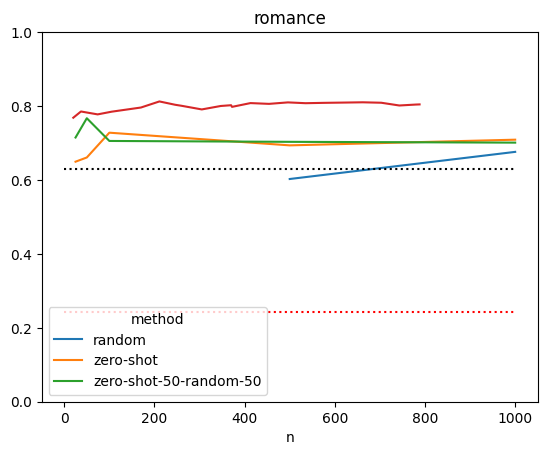

===


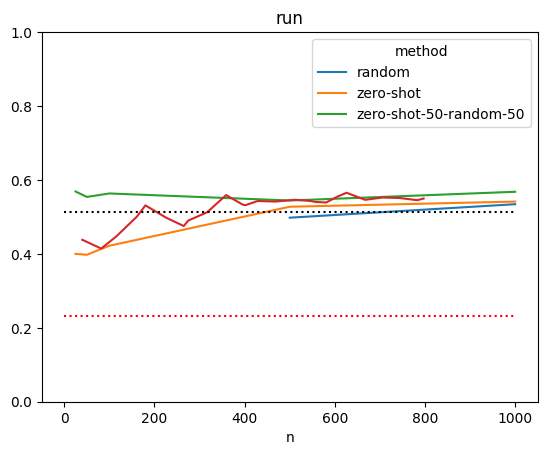

===


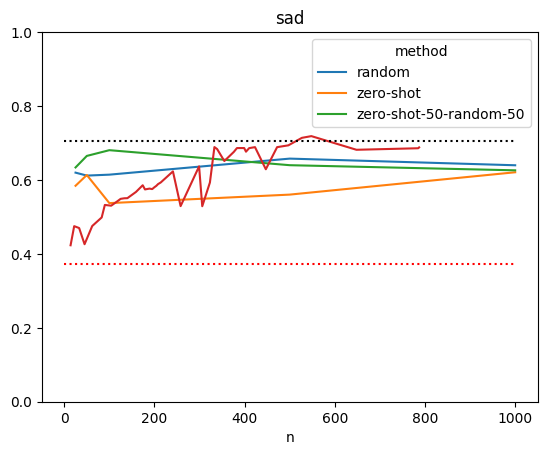

===


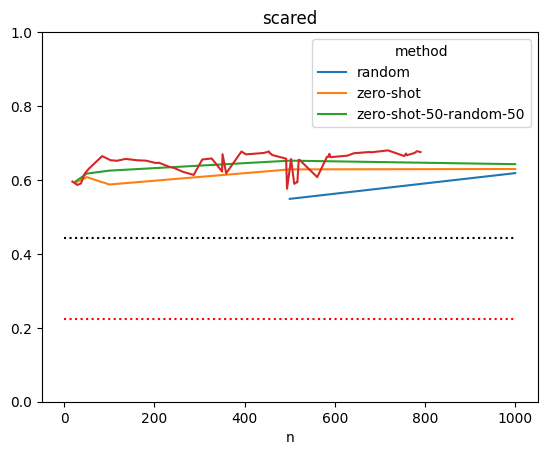

===


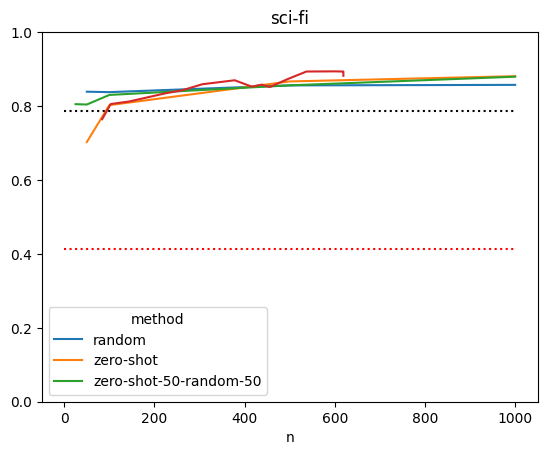

===
failed shutter-shot error: 'r'


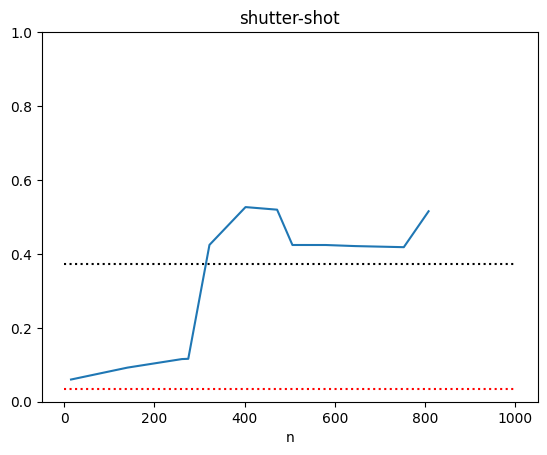

===


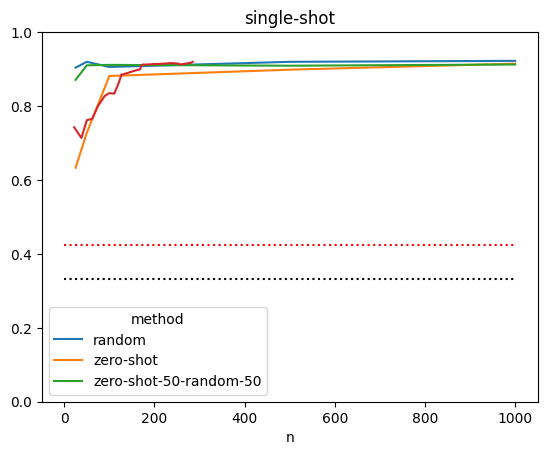

===


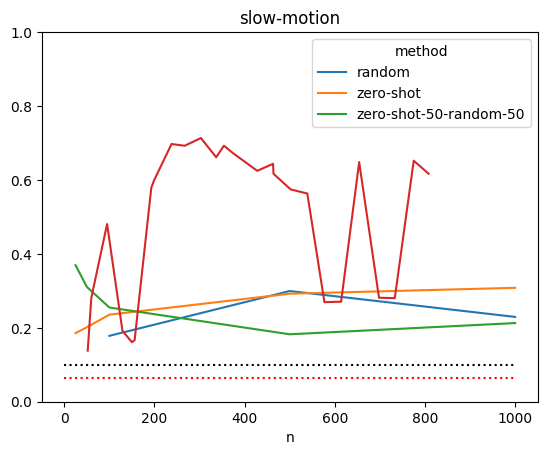

===


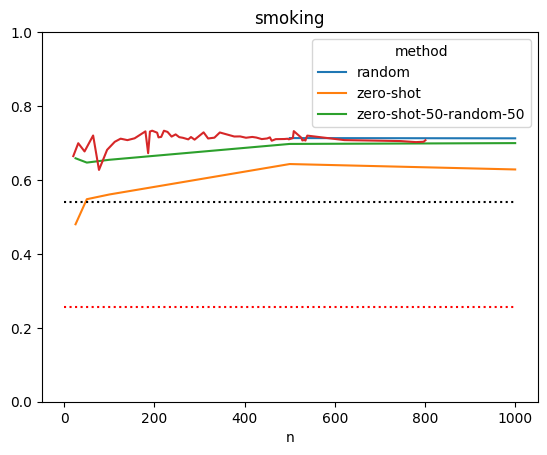

===


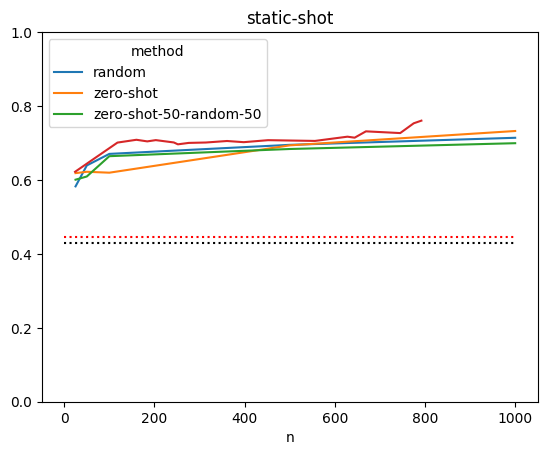

===


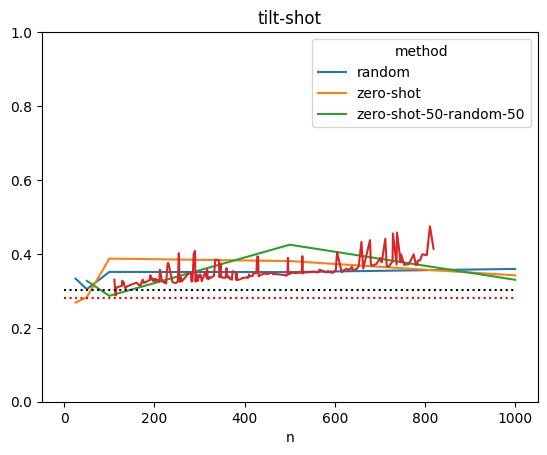

WARNING 2023-10-10 01:30:37,998 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:37,999 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,000 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,000 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,001 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,002 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,003 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,003 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 

===


WARNING 2023-10-10 01:30:38,049 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,050 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,050 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,051 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,052 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,053 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,053 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2023-10-10 01:30:38,054 experiments.py(32) Metric has NaN values: (0.3333333333

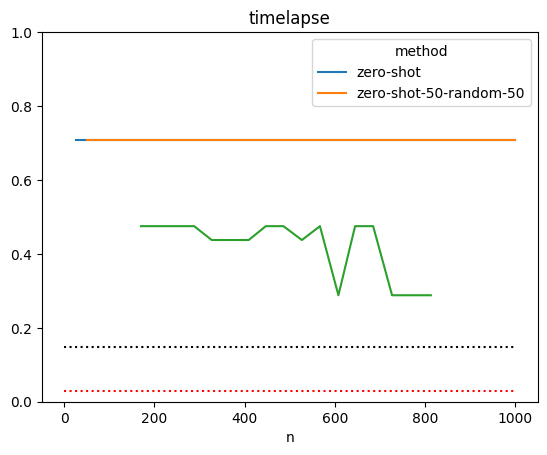

===


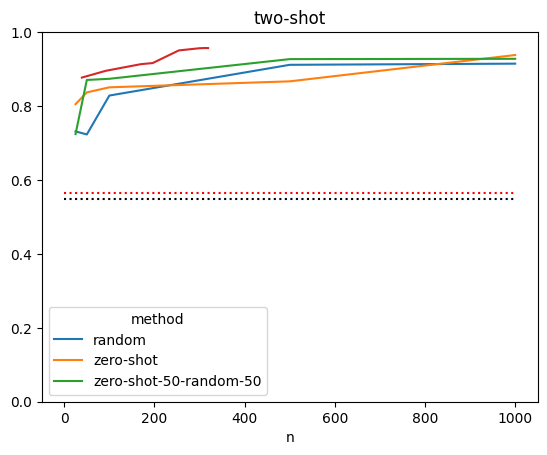

===


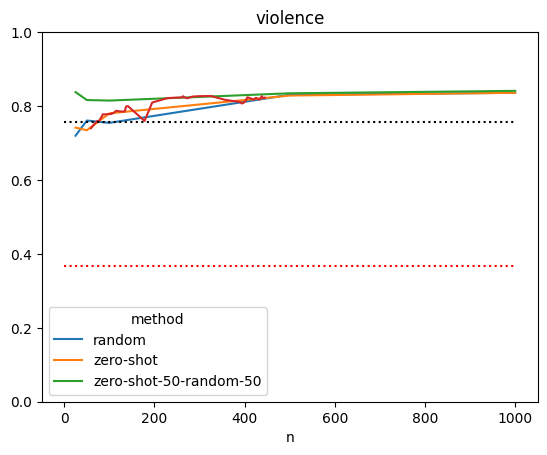

===


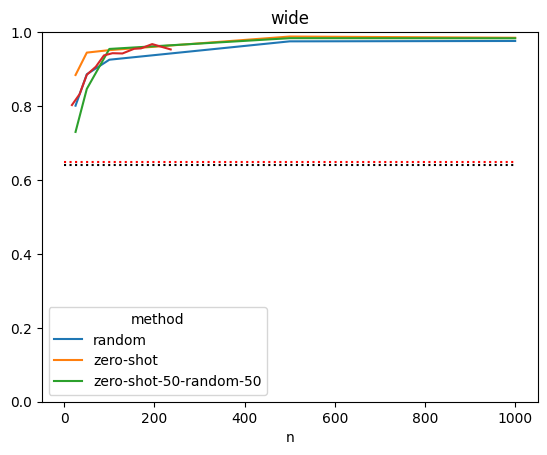

===


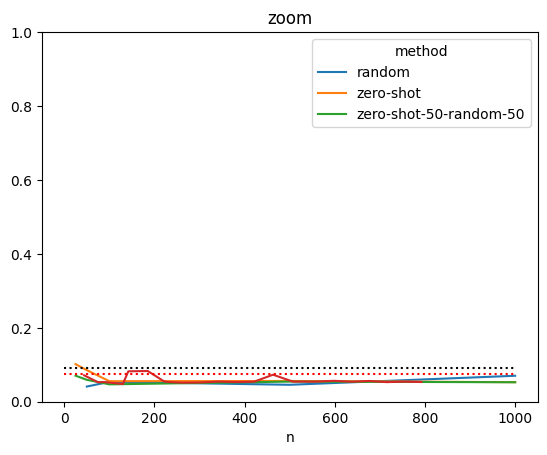

===


In [45]:
for k in sorted(res):
    plot(res, k)
    print('===')